<a href="https://colab.research.google.com/github/yehezkielgunawan/thesis-risk-classification/blob/main/RF_Classification_Indo_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install transformers
!pip install joblib

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Load the new dataset for sentiment classification
new_data = pd.read_excel('/content/gdrive/My Drive/Tesis/Compiled Classification Dataset.xlsx')
new_data.head(5)
sentences = new_data['content'].tolist()

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

# Load IndoBERT model
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Convert the sentences into input features
encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Perform word embedding using IndoBERT model
with torch.no_grad():
    outputs = model(**encoded_inputs)
    embeddings = outputs.last_hidden_state

# Convert the embeddings to numpy array
embeddings = embeddings.numpy()

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
new_data.head(5)

# Check the label distributions
priority_score_distribution = new_data['priority_score'].value_counts()
problem_domain_distribution = new_data['problem_domain'].value_counts()

print("Label priority_score Distribution:")
print(priority_score_distribution)

print("Label problem_domain Distribution:")
print(problem_domain_distribution)

Label priority_score Distribution:
3    277
2    275
1    148
Name: priority_score, dtype: int64
Label problem_domain Distribution:
0    569
1    131
Name: problem_domain, dtype: int64


In [15]:
# Assuming the labels for the new dataset are stored in two columns: 'label1' and 'label2'
priority_score = new_data['priority_score']
problem_domain = new_data['problem_domain']

# Reshape the embeddings array
num_samples = len(embeddings)
num_features = embeddings.shape[1] * embeddings.shape[2]
reshaped_embeddings = embeddings.reshape(num_samples, num_features)

# Split the reshaped embeddings into training and testing sets for label 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(reshaped_embeddings, priority_score, test_size=0.3, random_state=42)

# Split the reshaped embeddings into training and testing sets for label 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(reshaped_embeddings, problem_domain, test_size=0.3, random_state=42)


In [16]:
# Define the parameter grid for Grid Search for priority_score
param_grid1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 12],
    'min_samples_split': [5, 7, 10]
}

# Define the parameter grid for Grid Search for problem_domain
param_grid2 = {
    'n_estimators': [25, 75, 125],
    'max_depth': [None, 5, 12],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifiers
rf_classifier1 = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_classifier2 = RandomForestClassifier(class_weight="balanced", random_state=42)

# Perform Grid Search to find the best hyperparameters for priority_score
grid_search1 = GridSearchCV(estimator=rf_classifier1, param_grid=param_grid1, cv=5)
grid_search1.fit(X_train1, y_train1)

# Perform Grid Search to find the best hyperparameters for problem_domain
grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid2, cv=5)
grid_search2.fit(X_train2, y_train2)

# Get the best classifiers with the optimal hyperparameters
best_classifier1 = grid_search1.best_estimator_
best_classifier2 = grid_search2.best_estimator_

# Evaluate the best classifiers on the test sets for priority_score
y_pred1 = best_classifier1.predict(X_test1)
classification_rep1 = classification_report(y_test1, y_pred1)

# Evaluate the best classifiers on the test sets for problem_domain
y_pred2 = best_classifier2.predict(X_test2)
classification_rep2 = classification_report(y_test2, y_pred2)

print("Best Hyperparameters for priority_score:", grid_search1.best_params_)
print("Classification Report for priority_score:")
print(classification_rep1)

print("Best Hyperparameters for problem_domain:", grid_search2.best_params_)
print("Classification Report for problem_domain:")
print(classification_rep2)

Best Hyperparameters for priority_score: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.57      0.10      0.17        39
           2       0.42      0.65      0.51        80
           3       0.53      0.46      0.49        91

    accuracy                           0.47       210
   macro avg       0.51      0.40      0.39       210
weighted avg       0.49      0.47      0.44       210

Best Hyperparameters for problem_domain: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 25}
Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       172
           1       1.00      0.11      0.19        38

    accuracy                           0.84       210
   macro avg       0.92      0.55      0.55       210
weighted avg       0.86      0.84      0.78       210



In [17]:
# Function to plot confusion matrix
def plot_confusion_matrix_3x3(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_2x2(cm, title):
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

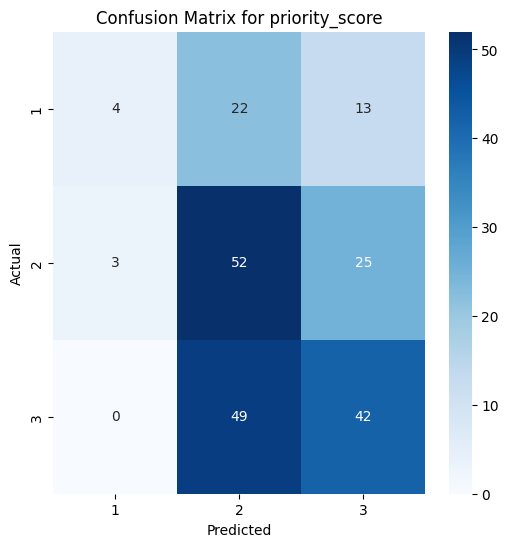

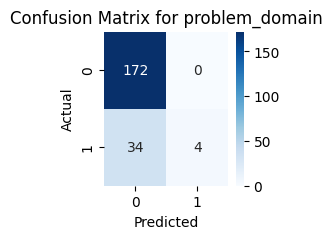

In [18]:
# Calculate confusion matrix for Label 1
cm1 = confusion_matrix(y_test1, y_pred1)

# Plot confusion matrix for Label 1
plot_confusion_matrix_3x3(cm1, title="Confusion Matrix for priority_score")

# Calculate confusion matrix for Label 2
cm2 = confusion_matrix(y_test2, y_pred2)

# Plot confusion matrix for Label 2
plot_confusion_matrix_2x2(cm2, title="Confusion Matrix for problem_domain")

In [19]:
# Map the top words to their corresponding labels for priority_score
top_words_map1 = {}
for i, label in enumerate(y_pred1):
    if label not in top_words_map1:
        top_words_map1[label] = []
    top_words_map1[label].append(sentences[i])

# Map the top words to their corresponding labels for problem_domain
top_words_map2 = {}
for i, label in enumerate(y_pred2):
    if label not in top_words_map2:
        top_words_map2[label] = []
    top_words_map2[label].append(sentences[i])

print("Top Words for Priority Score:")
for label, words in top_words_map1.items():
    print("Label", label, ":", words)

print("Top Words for Problem Domain:")
for label, words in top_words_map2.items():
    print("Label", label, ":", words)

Top Words for Priority Score:
Label 2 : ["Sorry, including the expensive price + apk using English for people who don't understand, it will be difficult to book", 'Setelah install terus pas buka aplikasi ngeblank putih', 'Aplilasi restart mulu', 'udah mahal , makanan ga enak, banyak lalat', 'duh ini berisik amat yg diatas. Pake peredam dong podnya.', 'ribet pemesanan nya, pelayanan nya juga kurang bagus', 'Tidak ad pertanggung jawaban atas ksalahan aplikasi dengan tgl yg pindah sendiri,playananan kurang ,membuat holiday menjadi bad dengan ad nya seperti ini', 'Makin kesini makin kesana harga bobobox, harga paling murahnya 300k yg single. Karuan nginep di hotel benernya sekalian', 'Stay bobobox bekasi untuk pelayanan resepsionisnya cwek kurang sopan dalam menghandle tamu tolong lebih di training dan di perbaiki lagi untuk pelayanan nya.terimakasih', 'Mau registrasi ajaa susah', 'Entah kenapa harganya naik melulu. Tapi fasilitas dan pelayanan nya makin berkurang', 'Kesan pertama udah tid

In [23]:
import joblib
# Export the best_classifier1 (priority_score model)
joblib.dump(best_classifier1, '/content/gdrive/My Drive/Tesis/best_classifier1.pkl')

# Export the best_classifier2 (problem_domain model)
joblib.dump(best_classifier2, '/content/gdrive/My Drive/Tesis/best_classifier2.pkl')

['/content/gdrive/My Drive/Tesis/best_classifier2.pkl']